In [1]:
from pathlib import Path
import patato as pat
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from paiskintonetools import setup_matplotlib

from paiskintonetools.correction_factor import get_correction_factor_interpolator

setup_matplotlib(300)

In [2]:
unmixer = pat.SpectralUnmixer(
    chromophores=["Hb", "HbO2"], wavelengths=[700.0, 730.0, 760.0, 800.0, 850.0]
)
correct = False


correction_factor_spline = get_correction_factor_interpolator(
    "../Fluence Correction/cali_curve.csv"
)

df_scans = pd.read_parquet("../01_Prepare Data/scan_table.parquet")
df_scans = df_scans.query("SkinID=='SKIN36' and Region=='Carotid Artery'").set_index(
    "ScanNumber"
)[["ITA"]]

In [3]:
# wavelength = np.linspace(700, 900)
# mvf = np.logspace(np.log10(0.02), np.log10(0.4), 6)
# for i in mvf:
#     plt.plot(wavelength, np.exp(-correction_factor_spline((wavelength, i))))
# plt.show()
# df_scans.loc[[21, 22, 23]] = 40
# df_scans.loc[[18,19,20]] = 20

In [ ]:
import json

settings = json.load(open("../data_paths.json", "r"))
root_data_path = (Path.cwd() / "../" / settings["vitiligo_data_path"]).resolve()

data_folder = root_data_path / "SKIN36"
measurements = defaultdict(list)
measurements_corrected = defaultdict(list)

for f in data_folder.glob("*.hdf5"):
    pa = pat.PAData.from_hdf5(f)
    scan_number = int(f.stem.split("_")[-1])
    pa.set_default_recon(("Model Based", "0"))
    if scan_number not in df_scans.index:
        pa.scan_reader.file.close()
        continue
    ita = df_scans.loc[scan_number, "ITA"]
    if ("reference_", "0") not in pa.get_rois():
        pa.scan_reader.file.close()
        continue
    else:
        r = pa.get_rois()["reference_", "0"]
        rec = pa.get_scan_reconstructions()
        rec.raw_data = np.array(rec.raw_data)

        # plt.imshow(np.squeeze(thb), origin="lower")
        # plt.imshow(np.squeeze(rec.raw_data[:, 3]), origin="lower")
        mask, _ = r.to_mask_slice(rec)
        # plt.contour(np.squeeze(mask), origin="lower")
        mask[np.any(rec.raw_data[0, :4] < 0, axis=0)] = False

        um = unmixer.run(rec, None)[0]
        rd = um.raw_data[0]

        so2 = rd[1] / (rd[0] + rd[1])
        thb = rd[1] + rd[0]

        mask[so2 < 0] = False
        mask[so2 > 1] = False

        mask[thb < np.percentile(thb[mask], 70)] = False
        # plt.contour(np.squeeze(mask), origin="lower")
        # plt.title(pa.get_scan_name())
        # plt.show()
        hb, hbo2 = np.mean(rd[0][mask]), np.median(rd[1][mask])
        so2_calc = hbo2 / (hb + hbo2)
        print(so2_calc, pa.get_scan_name())
        measurements[pa.get_scan_name().split("-")[1]].append(
            so2_calc * 100
        )  # np.mean(so2[mask])*100)

        mvf = (19.028 - 0.3692 * ita + 0.001685 * ita**2) / 100
        rec.raw_data *= np.exp(
            correction_factor_spline((rec.wavelengths, mvf))[None, :, None, None, None]
        )
        # Rerun the unmixing.
        um = unmixer.run(rec, None)[0]
        rd = um.raw_data[0]
        so2 = rd[1] / (rd[0] + rd[1])

        hb, hbo2 = np.mean(rd[0][mask]), np.median(rd[1][mask])
        so2_calc = hbo2 / (hb + hbo2)
        measurements_corrected[pa.get_scan_name().split("-")[1]].append(
            so2_calc * 100
        )  # np.mean(so2[mask])*100)

0.8832594 neck-pigment-a
0.9051826 neck-pigment-b
0.93035203 neck-pigment-c
0.8791436 neck-nopigment-a
0.85608304 neck-nopigment-b
0.8655163 neck-nopigment-c


In [12]:
measurements

defaultdict(list,
            {'pigment': [88.32594156265259,
              90.51826000213623,
              93.03520321846008],
             'nopigment': [87.91435956954956,
              85.60830354690552,
              86.55163049697876]})

In [13]:
dfs = [pd.DataFrame(x) for x in [measurements, measurements_corrected]]
df = pd.concat(dfs, axis=1)

In [14]:
m = dfs[0].mean()
s = dfs[0].std() / np.sqrt(3)
display(m)
display(s)

pigment      90.626468
nopigment    86.691431
dtype: float64

pigment      1.360523
nopigment    0.669361
dtype: float64

In [15]:
print(ttest_ind(dfs[0]["pigment"], dfs[0]["nopigment"], alternative="greater"))
print(ttest_ind(dfs[1]["pigment"], dfs[1]["nopigment"], alternative="greater"))

print(
    dfs[0]["pigment"].mean() - dfs[0]["nopigment"].mean(),
    dfs[1]["pigment"].mean() - dfs[1]["nopigment"].mean(),
)
print(
    dfs[0]["pigment"].mean()
    - dfs[0]["nopigment"].mean()
    - (dfs[1]["pigment"].mean() - dfs[1]["nopigment"].mean())
)

TtestResult(statistic=2.5952132383248143, pvalue=0.030175753161010743, df=4.0)
TtestResult(statistic=1.0415953946138279, pvalue=0.17820613904268987, df=4.0)
3.9350370566050117 1.7895758152008057
2.145461241404206


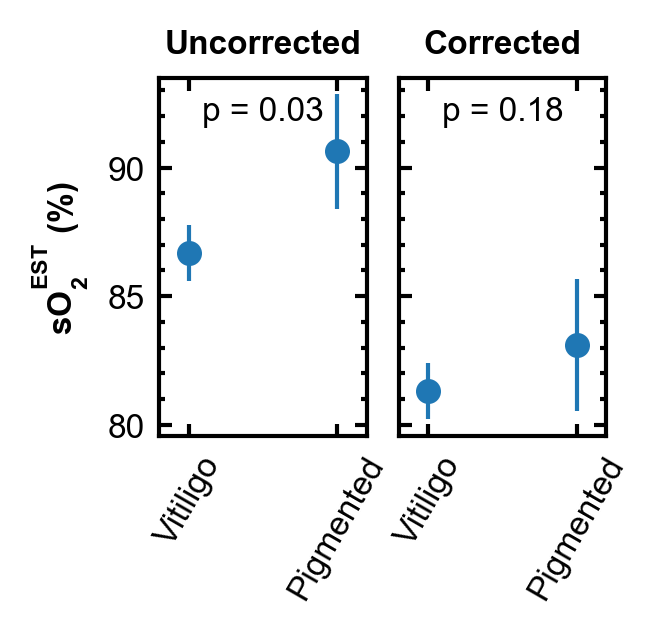

In [16]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(2, 2), sharex=True, sharey=True, gridspec_kw={"wspace": 0.0}
)
fig.get_layout_engine().set(w_pad=0)
m = np.mean(df.values, axis=0)
s = np.std(df.values, axis=0) * 2 / np.sqrt(3)
ax1.errorbar([1, 0], m[:2], yerr=s[:2], fmt="o")
ax2.errorbar([1, 0], m[2:], yerr=s[2:], fmt="o")
ax1.set_xticks([0, 1], ["Vitiligo", "Pigmented"], rotation=60)
ax2.set_xticks([0, 1], ["Vitiligo", "Pigmented"], rotation=60)
ax1.set_xticks([], [], minor=True)
# for i, x in enumerate(ax1.xaxis.get_ticklabels()):
#     x.set_ha("left" if i == 0 else "right")
# for i, x in enumerate(ax2.xaxis.get_ticklabels()):
#     x.set_ha("left" if i == 0 else "right")
ax1.set_xlim([-0.2, 1.2])
ax1.set_title("Uncorrected", fontsize="medium")
ax2.set_title("Corrected", fontsize="medium")
ax1.set_ylabel(r"$\mathdefault{sO_2^{EST}}$ (%)")
ax1.text(0.5, 0.95, "p = 0.03", transform=ax1.transAxes, va="top", ha="center")
ax2.text(0.5, 0.95, "p = 0.18", transform=ax2.transAxes, va="top", ha="center")
fig.savefig("so2_vitiligo_carotid_correction.pdf", dpi=300)
plt.show()

In [19]:
m = dfs[0].mean()
s = dfs[0].std() / np.sqrt(3)
display(m)
display(s)

pigment      90.626468
nopigment    86.691431
dtype: float64

pigment      1.360523
nopigment    0.669361
dtype: float64

In [20]:
delta = m["pigment"] - m["nopigment"]
uncertainty = np.linalg.norm(s)

print(f"{delta:.2f}±{uncertainty:.2f}")

3.94±1.52


In [21]:
predicted = 3.196
np.abs((predicted - delta) / uncertainty)

0.4874055124067032